In [1]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

I am interested in comparing the top words for each subreddit, to see if there are any interesting differences. I will run a countvectorizer on the dataset for each subreddit, and then compare the results.

# Creating document with weighted word counts

In [29]:
raw = pd.read_csv('../jsons/very_clean_data.csv')

In [30]:
true_film = raw.loc[raw['target'] == 1]
flicks = raw.loc[raw['target'] == 0]

In [4]:
raw['target'].value_counts(normalize=True)

1    0.730995
0    0.269005
Name: target, dtype: float64

In [5]:
raw['target'].value_counts()

1    61973
0    22806
Name: target, dtype: int64

In [4]:
cvec = CountVectorizer(stop_words='english', min_df=.0001,max_features=30000,ngram_range=(1,4))

In [5]:
def top_sub_words(sub):    
    
    sub_cvec = cvec.fit_transform(sub['text'])
    sub_cvec = pd.SparseDataFrame(sub_cvec, columns=cvec.get_feature_names())
    sub_cvec.fillna(0,inplace=True)
    transposed = sub_cvec.T
    transposed['count'] = transposed[list(transposed.columns)].sum(axis=1)
    transposed['adjusted_count'] = (transposed['count'] / len(sub)) * 1000

    return transposed[['count','adjusted_count']].reset_index()

In [6]:
flicks_top = top_sub_words(flicks)

In [7]:
flicks_top.columns = ['index','count_flicks','adjusted_count']

In [8]:
flicks_top.sort_values('count_flicks',ascending=False).head(10)

,index,count_flicks,adjusted_count
16601,movie,15114.0,664.877705
8913,film,13196.0,580.503255
13957,like,8364.0,367.939469
26103,think,5462.0,240.278022
21141,really,5409.0,237.946507
26626,time,4508.0,198.310751
10865,good,4193.0,184.453634
3645,character,3738.0,164.437797
19074,people,3527.0,155.155728
11147,great,3204.0,140.946683


In [9]:
truefilm_top = top_sub_words(true_film)

In [10]:
truefilm_top.columns = ['index','count_truefilm','adjusted_count']

In [11]:
truefilm_top.sort_values('count_truefilm',ascending=False).head(10)

,index,count_truefilm,adjusted_count
8749,film,62475.0,1011.233227
16936,movie,40675.0,658.373934
14349,like,30195.0,488.742494
26170,think,23143.0,374.597368
21377,really,17189.0,278.224697
26641,time,15254.0,246.904388
19233,people,14952.0,242.016154
3601,character,13654.0,221.006458
15608,make,12493.0,202.214273
28863,way,12349.0,199.883459


In [12]:
flicks_top['sub'] = 0

In [13]:
truefilm_top['sub'] = 1

In [14]:
flicks_top_words = flicks_top[['index','count_flicks','adjusted_count']]

In [15]:
truefilm_top_words = truefilm_top[['index','count_truefilm','adjusted_count']]

In [16]:
flicks_top_words.columns = ['words','count_flicks','adjusted_count_flicks']
truefilm_top_words.columns = ['words','count_truefilm','adjusted_count_truefilm']

In [17]:
len(flicks_top_words.sort_values('adjusted_count_flicks',ascending=False))

30000

In [18]:
len(truefilm_top_words.sort_values('adjusted_count_truefilm',ascending=False))

30000

In [22]:
merged2 = pd.merge(flicks_top_words.to_dense(), truefilm_top_words.to_dense(), on='words', how='outer')

In [23]:
merged2.fillna(0,inplace=True)

In [24]:
merged2.head()

,words,count_flicks,adjusted_count_flicks,count_truefilm,adjusted_count_truefilm
0,aaron,14.0,0.615872,69.0,1.116848
1,aback,10.0,0.439908,25.0,0.404655
2,abacus,5.0,0.219954,0.0,0.000000
3,abacus small,4.0,0.175963,0.0,0.000000
4,abacus small jail,4.0,0.175963,0.0,0.000000


Create a column called 'delta' which is the difference between the "adjusted count" of a word in 'flicks', compared to 'truefilm.'

Also creating another column called 'delta_abs', which is the absolute difference of a word's 'adjusted count'

In [25]:
merged2['delta'] = merged2['adjusted_count_flicks'] - merged2['adjusted_count_truefilm']

In [26]:
merged2['delta_abs'] = merged2['delta'].abs()

In [33]:
merged2.to_csv('./jsons/big_wordcount_list.csv')

# Exploratory Data Analysis with weighted word count list

In [6]:
word_list = pd.read_csv('../jsons/big_wordcount_list.csv')

First, look at words used more frequently in 'flicks', than 'truefilm.'

In [28]:
word_list.sort_values('delta',ascending=False).head(10)

,Unnamed: 0,words,count_flicks,adjusted_count_flicks,count_truefilm,adjusted_count_truefilm,delta,delta_abs
10282,10282,fun,1057.0,46.498328,1865.0,30.187274,16.311054,16.311054
18510,18510,original,1137.0,50.017596,2411.0,39.024943,10.992653,10.992653
23298,23298,season,417.0,18.344184,471.0,7.623703,10.720481,10.720481
23612,23612,sequel,499.0,21.951434,733.0,11.864489,10.086945,10.086945
14968,14968,loved,935.0,41.131445,2010.0,32.534274,8.597170,8.597170
27153,27153,trailer,404.0,17.772303,583.0,9.436558,8.335745,8.335745
3937,3937,christmas,262.0,11.525603,201.0,3.253427,8.272175,8.272175
7694,7694,episode,465.0,20.455745,815.0,13.191758,7.263987,7.263987
16601,16601,movie,15114.0,664.877705,40675.0,658.373934,6.503772,6.503772
7550,7550,enjoyed,729.0,32.069330,1586.0,25.671323,6.398007,6.398007


Now let's look at words used a lot in 'TrueFilm', compared to 'flicks'. 

In [13]:
word_list.sort_values('delta',ascending=True).head(18)

,Unnamed: 0,words,count_flicks,adjusted_count_flicks,count_truefilm,adjusted_count_truefilm,delta,delta_abs
8913,8913,film,13196.0,580.503255,62475.0,1011.233227,-430.729972,430.729972
26103,26103,think,5462.0,240.278022,23143.0,374.597368,-134.319346,134.319346
13957,13957,like,8364.0,367.939469,30195.0,488.742494,-120.803025,120.803025
19074,19074,people,3527.0,155.155728,14952.0,242.016154,-86.860426,86.860426
15238,15238,make,3068.0,134.963928,12493.0,202.214273,-67.250345,67.250345
28872,28872,way,3030.0,133.292275,12349.0,199.883459,-66.591184,66.591184
3645,3645,character,3738.0,164.437797,13654.0,221.006458,-56.568661,56.568661
19836,19836,point,1611.0,70.869259,7717.0,124.908953,-54.039693,54.039693
25967,25967,thing,2851.0,125.417913,11053.0,178.906136,-53.488223,53.488223
29414,29414,work,1702.0,74.872427,7925.0,128.275683,-53.403257,53.403257


In [26]:
word_list.loc[word_list['count_flicks']  < 115].sort_values('count_truefilm',ascending=False).head(15)

,Unnamed: 0,words,count_flicks,adjusted_count_flicks,count_truefilm,adjusted_count_truefilm,delta,delta_abs
12780,12780,interpretation,113.0,4.970966,1129.0,18.274227,-13.303261,13.303261
10170,10170,french,103.0,4.531058,1035.0,16.752723,-12.221666,12.221666
16522,16522,moral,98.0,4.311103,906.0,14.664703,-10.353599,10.353599
16599,16599,movement,113.0,4.970966,855.0,13.839206,-8.868240,8.868240
21991,21991,response,106.0,4.663030,828.0,13.402179,-8.739149,8.739149
25681,25681,tarkovsky,57.0,2.507478,818.0,13.240317,-10.732838,10.732838
1307,1307,artistic,114.0,5.014957,793.0,12.835661,-7.820705,7.820705
2111,2111,bergman,90.0,3.959176,783.0,12.673799,-8.714623,8.714623
12537,12537,individual,75.0,3.299314,778.0,12.592868,-9.293555,9.293555
22154,22154,rey,90.0,3.959176,738.0,11.945420,-7.986244,7.986244


In [22]:
word_list.loc[word_list['count_truefilm']  < 125].sort_values('count_flicks',ascending=False).head(20)

,Unnamed: 0,words,count_flicks,adjusted_count_flicks,count_truefilm,adjusted_count_truefilm,delta,delta_abs
13208,13208,jurassic park,122.0,5.366884,114.0,1.845227,3.521656,3.521656
4189,4189,cmv,121.0,5.322893,0.0,0.000000,5.322893,5.322893
5657,5657,deadpool,103.0,4.531058,103.0,1.667179,2.863878,2.863878
12878,12878,isle,97.0,4.267112,100.0,1.618621,2.648492,2.648492
777,777,aliens,95.0,4.179131,114.0,1.845227,2.333903,2.333903
25396,25396,superman,94.0,4.135140,121.0,1.958531,2.176609,2.176609
12497,12497,incredibles,91.0,4.003167,75.0,1.213965,2.789202,2.789202
24901,24901,stephen,89.0,3.915186,112.0,1.812855,2.102331,2.102331
18237,18237,ocean,87.0,3.827204,116.0,1.877600,1.949604,1.949604
10635,10635,ghostbusters,82.0,3.607250,74.0,1.197779,2.409470,2.409470


In [ ]:
When a similar 

In [31]:
raw['word_count'] = raw.text.map(lambda x: len(x.split()))

In [34]:
true_film = raw.loc[raw['target'] == 1]
flicks = raw.loc[raw['target'] == 0]

In [35]:
raw.pivot_table(index=['target'], aggfunc='mean')

,word_count
target,
0,38.682978
1,54.781340


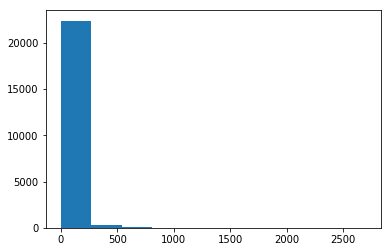

In [36]:
plt.hist(flicks['word_count'],bins=10);

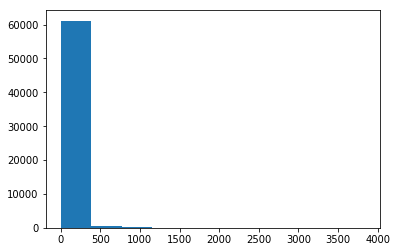

In [37]:
plt.hist(true_film['word_count'],bins=10);

In [49]:
len(true_film.loc[true_film['word_count'] > 50]) / len(true_film)

0.30200248495312476

In [50]:
len(flicks.loc[flicks['word_count'] > 50]) / len(flicks)

0.17995264404104183

In [38]:
len(flicks.loc[flicks['word_count'] < 10]) / len(flicks)

0.2868981846882399

In [40]:
len(true_film.loc[true_film['word_count'] < 10]) / len(true_film)

0.16666935600987526